In [1]:
from driver import *
from MNIST_LARGE_cfg import *
from pynq import Overlay
import numpy as np
from pynq import Xlnk
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
ol=Overlay("pool_stream.bit")
ol.download();
dma=ol.axi_dma_0
pool=ol.pool_0
conv=ol.Conv_0

In [3]:
xlnk=Xlnk()
image=xlnk.cma_array(shape=(1,28,28,K),cacheable=0,dtype=np.int16)
W_conv1=xlnk.cma_array(shape=(32,3,3,1,K),cacheable=0,dtype=np.int16)
h_conv1=xlnk.cma_array(shape=(4,28,28,K),cacheable=0,dtype=np.int16)
h_pool1=xlnk.cma_array(shape=(4,7,7,K),cacheable=0,dtype=np.int16)
W_fc1=xlnk.cma_array(shape=(256,7,7,4,K),cacheable=0,dtype=np.int16)
h_fc1=xlnk.cma_array(shape=(32,1,1,K),cacheable=0,dtype=np.int16)
W_fc2=xlnk.cma_array(shape=(10,1,1,32,K),cacheable=0,dtype=np.int16)
h_fc2=xlnk.cma_array(shape=(2,1,1,K),cacheable=0,dtype=np.int16)

In [4]:
Load_Weight_From_File(W_conv1,"record/W_conv1.bin")
Load_Weight_From_File(W_fc1,"record/W_fc1.bin")
Load_Weight_From_File(W_fc2,"record/W_fc2.bin")

cap=cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,480)
print("capture state: "+ str(cap.isOpened()))

ret, frame=cap.read();ret, frame=cap.read();ret, frame=cap.read();ret, frame=cap.read();ret, frame=cap.read();

np.shape(frame)

frame_300x300=frame[90:390,170:470]
frame_28x28=255-cv2.resize(frame_300x300,(28,28),interpolation=cv2.INTER_NEAREST)
img_gray=cv2.cvtColor(frame_28x28,cv2.COLOR_RGB2GRAY)
plt.imshow(cv2.merge([img_gray,img_gray,img_gray]))
plt.show()

#print((img_gray/255*pow(2,PTR_IMG)))
img_gray=(img_gray/255*pow(2,PTR_IMG))
print(img_gray.max())

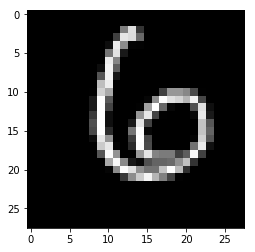

In [2]:
test_pic=100
img_gray=np.zeros((28,28))
with open("record/t10k-images.idx3-ubyte",'rb') as fp:
    dat=fp.read(16+28*28*test_pic)
    for i in range(28):
        for j in range(28):
            dat=fp.read(1)
            a=struct.unpack("B",dat)
            img_gray[i][j]=a[0]
            #print(a[0])
img_gray=img_gray.astype(np.uint8)
# for i in range(28):
#     for j in range(28):
#         print("%4d"%img_gray[i][j],end='')
#     print('')
plt.imshow(cv2.merge([img_gray,img_gray,img_gray]))
plt.show()

In [10]:
for i in range(np.shape(img_gray)[0]):
    for j in range(np.shape(img_gray)[1]):
        image[0][i][j][0]=int((img_gray[i][j]/255)*(2**PTR_IMG));

In [11]:
start=time.time()
Run_Conv(conv,1,32,3,3,1,1,1,0,image,PTR_IMG,W_conv1,PTR_W_CONV1,h_conv1,PTR_H_CONV1)
#Run_Pool_Soft(32,4,4,h_conv1,h_pool1)
Run_Pool(pool,dma,32,4,4,h_conv1,h_pool1)
Run_Conv(conv,32,256,7,7,1,1,0,0,h_pool1,PTR_H_POOL1,W_fc1,PTR_W_FC1,h_fc1,PTR_H_FC1)
Run_Conv(conv,256,10,1,1,1,1,0,0,h_fc1,PTR_H_FC1,W_fc2,PTR_W_FC2,h_fc2,PTR_H_FC2)
end=time.time()
print("Hardware run time=%s s"%(end-start))

Hardware run time=0.03557157516479492 s


In [12]:
max=-32768
num=0
for i in range(10):
    if(h_fc2[i//K][0][0][i%K]>max):
        max=h_fc2[i//K][0][0][i%K]
        num=i;
print("predict num is %d"%num);

predict num is 6
